In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
from io import StringIO

warnings.filterwarnings("ignore")

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

req = requests.get(url)
if req.status_code == 200:
    df = pd.read_csv(StringIO(req.text))
    print(df.head())

  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         C

In [3]:
df_car = df.copy()
df_car.drop(['Engine Fuel Type', 'Driven_Wheels', 'Number of Doors', 'Market Category', 
             'Vehicle Size', 'Popularity'], axis=1, inplace=True)

In [4]:
df_car.columns = df_car.columns.str.replace(' ', '_').str.lower()

In [5]:
df_car.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


## Question 1

In [6]:
df_car['transmission_type'].value_counts()

transmission_type
AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: count, dtype: int64

Automatic

## Question 2

In [7]:
# Correlation matrix
correlation_matrix = df_car[['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'msrp']].corr()
correlation_matrix

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,msrp
year,1.000000,0.351794,-0.041479,0.258240,0.198171,0.227590
engine_hp,0.351794,1.000000,0.779988,-0.406563,-0.439371,0.662008
engine_cylinders,-0.041479,0.779988,1.000000,-0.621606,-0.600776,0.531312
highway_mpg,0.258240,-0.406563,-0.621606,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.439371,-0.600776,0.886829,1.000000,-0.157676
msrp,0.227590,0.662008,0.531312,-0.160043,-0.157676,1.000000


<Axes: >

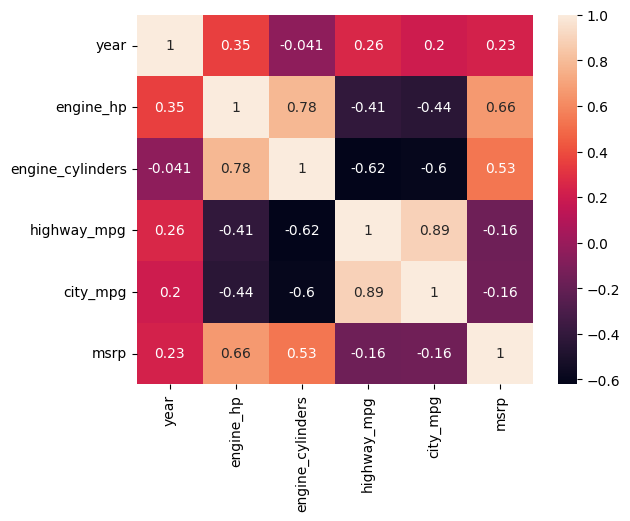

In [8]:
sns.heatmap(correlation_matrix, annot=True)

- strong positive: engine_cylinders and engine_hp
- strong negative: engine_cylinders and highway_mpg

In [9]:
# Make Price binary
mean_msrp = df_car['msrp'].mean()

df_car['above_average'] = (df_car['msrp'] > mean_msrp).astype(int)
df_car.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500,0


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_train_full, df_tes = train_test_split(df_car, test_size=0.4, random_state=42)

df_train, df_val = train_test_split(df_train_full, test_size=0.4, random_state=42)

In [12]:
y_train = df_train['above_average'].values
y_val = df_val['above_average'].values

In [13]:
del df_train['above_average']
del df_val['above_average']

## Question 3

In [14]:
categorical_columns = ['make', 'model', 'transmission_type', 'vehicle_style']

numerical_columns = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'msrp']

In [15]:
from sklearn.metrics import mutual_info_score

In [16]:
def calculate_mi(series):
    return mutual_info_score(series, df_train_full['above_average'])

df_mi = df_train_full[categorical_columns].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='Mutual_Info')


display(df_mi.head())
display(df_mi.tail())

,Mutual_Info
model,0.463623
make,0.235285
vehicle_style,0.082958
transmission_type,0.021197


,Mutual_Info
model,0.463623
make,0.235285
vehicle_style,0.082958
transmission_type,0.021197


Lowest mutual score: transmission_type

## Question 4

In [17]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

train_dict[0]

{'make': 'Land Rover',
 'model': 'Range Rover Sport',
 'transmission_type': 'AUTOMATIC',
 'vehicle_style': '4dr SUV',
 'year': 2016,
 'engine_hp': 340.0,
 'engine_cylinders': 6.0,
 'highway_mpg': 23,
 'city_mpg': 17,
 'msrp': 64950}

In [18]:
dictvec = DictVectorizer(sparse=False)
dictvec.fit(train_dict)

X_train = dictvec.transform(train_dict)

In [19]:
y_train.shape

(4288,)

In [20]:
from sklearn.impute import SimpleImputer

# Create an imputer to fill missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and validation data
X_train_imputed = imputer.fit_transform(X_train)


# Now, you can fit the Logistic Regression model on the imputed data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train_imputed, y_train)


LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [22]:
from sklearn.metrics import accuracy_score

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dictvec.transform(val_dict)

# fill missing value of X_val
X_val_imputed = imputer.transform(X_val)

# Predict on the validation dataset
y_val_pred = model.predict(X_val_imputed)

# Calculate accuracy on the validation dataset
accuracy = accuracy_score(y_val, y_val_pred)

# Round the accuracy to 2 decimal digits
rounded_accuracy = accuracy

# Print the rounded accuracy
print(f"Accuracy on the validation dataset: {rounded_accuracy}")


Accuracy on the validation dataset: 0.9996503496503496


## Question 5

In [32]:
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=['make', 'model', 'year', 'engine_hp', 'engine_cylinders', 
                                                            'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg', 'msrp'])

ValueError: Shape of passed values is (4288, 885), indices imply (4288, 10)

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# Record the original accuracy
accuracy_all = accuracy_score(y_val, model.predict(X_val_imputed))

# Create a list of all columns
all_columns = list(X_train_imputed_df.columns)

# Loop through each feature and evaluate accuracy without it
accuracy_without_feature = []
for i, feature in enumerate(all_columns):
    # Exclude the feature from the training and validation datasets
    X_train_without_feature = X_train.drop(feature, axis=1)
    X_val_without_feature = X_val.drop(feature, axis=1)

    # Train the model on the training dataset without the feature
    model.fit(X_train_without_feature, y_train)

    # Make predictions on the validation dataset without the feature
    y_val_pred = model.predict(X_val_without_feature)

    # Calculate the accuracy on the validation dataset without the feature
    accuracy = accuracy_score(y_val, y_val_pred)

    # Append the accuracy to the list
    accuracy_without_feature.append(accuracy)

# Calculate the difference between the original accuracy and the accuracy without each feature
difference_in_accuracy = [accuracy_all - accuracy for accuracy in accuracy_without_feature]

# Find the feature with the smallest difference in accuracy
least_useful_feature = all_columns[difference_in_accuracy.index(min(difference_in_accuracy))]

# Print the least useful feature
print(f'The least useful feature is {least_useful_feature}')



NameError: name 'X_train_imputed_df' is not defined

## Question 6

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

# Load the data
data = pd.read_csv('data.csv')

# Apply the logarithmic transformation to the `price` column
data['price_log'] = np.log1p(data['price'])

# Set the seed
np.random.seed(42)

# Create a list of alpha values to try
alpha_values = [0, 0.01, 0.1, 1, 10]

# Train a Ridge regression model with each alpha value
rmse_scores = []
for alpha in alpha_values:
    model = Ridge(solver='sag', alpha=alpha)
    model.fit(X_train, y_train)

    # Make predictions on the validation dataset
    y_val_pred = model.predict(X_val)

    # Calculate the RMSE score on the validation dataset
    rmse_score = np.sqrt(mean_squared_error(y_val, y_val_pred))

    # Append the RMSE score to the list
    rmse_scores.append(rmse_score)

# Round the RMSE scores to 3 decimal digits
rmse_scores = [round(score, 3) for score in rmse_scores]

# Print the RMSE scores
print(f'RMSE scores: {rmse_scores}')
